In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np

#### temporal kernel in time domain (IFT from Bernadete and Kaplan 1997)
$$f(t)=A\left(\frac{1}{(N_{L}-1)!}\frac{t^{N_{L}-1}}{\tau_{L}^{N_L}}+\frac{H_{S}}{\tau_{S}}\left(\frac{\tau_{M}}{\tau_{L}}\right)^{N_{L}}\sum_{i=0}^{N_{L}-1}{\frac{1}{i!}\left(\frac{t}{\tau_{M}}\right)^{i}}\right)e^{-t/\tau_{L}} - \frac{H_{S}}{\tau_{S}}\left(\frac{\tau_{M}}{\tau_{L}}\right)^{N_{L}}e^{-t/\tau_{S}}$$
#### fitted by generalized alpha function
$$f(t) = \frac{A_{r}}{(n_{r}-1)!}\frac{t^{n_{r}-1}}{\tau_{r}^{n_{r}}}e^{-t/\tau_{r}} - \frac{A_{d}}{(n_{d}-1)!}\frac{t^{n_{d}-1}}{\tau_{d}^{n_{d}}}e^{-t/\tau_{d}}$$

$n_{r}, n_{d}$ to match the coefficient of variance with $N_{L}$,

$A_{r}, A_{d} \to A$

$\tau_{r} \to \tau_{L}$

$\tau_{d} \to \tau_{S}$


In [3]:
from scipy.special import gamma
np.seterr(over='raise')
def temporalKernel(A, HS, tauS, NL, tauL, D, t):
    t = t - D
    tpick = t > 0
    active_t = t[tpick]
    Kt = np.zeros(t.shape)
    sums = np.zeros(t.shape)
    
    tauM = tauS*tauL/(tauS-tauL)
    B = HS/tauS*np.float_power(tauM/tauL,NL)
    NL_int = np.ceil(NL).astype(int)
    for i in range(NL_int):
        if i == NL_int-2 and NL_int > NL:
            r = (NL - NL_int + 1)
        else:
            r = 1
        sums[tpick] = sums[tpick] + r * np.power(active_t/tauM,i)/np.math.factorial(i)
        
    Kt[tpick] = A*((np.float_power(active_t/tauL,NL-1)/tauL/gamma(NL) + B*sums[tpick]) * np.exp(-active_t/tauL) - B*np.exp(-active_t/tauS))
    return Kt#*np.sqrt(2*np.pi)

def temporalKernel_alt(A, HS, tauS, NL, tauL, D, t):
    t = t - D
    tpick = t > 0
    active_t = t[tpick]
    Kt = np.zeros(t.shape)
    sums = np.zeros(t.shape)
    
    tauM = tauS-tauL
    NL_int = (np.floor(NL) + 1).astype(int)
    for i in range(1, NL_int):
        sums[tpick] = sums[tpick] + np.float_power(tauS/tauM, i-1)/tauM * np.float_power(active_t/tauL, NL-i)/gamma(NL-i+1)
    
    Q = np.float_power(active_t/tauL,NL-1)/tauL/gamma(NL)
    P = HS*np.float_power(tauS/tauM, NL-1)/tauM
    Kt[tpick] = A*((Q + HS*sums[tpick]) * np.exp(-active_t/tauL) - P*np.exp(-active_t/tauS))
    return Kt#*np.sqrt(2*np.pi)


def temporalComp(A,tau,n,d,t):
    #fac = np.math.factorial(n-1)
    fac = gamma(n)
    t = t-d
    Kt = np.zeros(t.shape)
    tpick = t>0
    active_t = t[tpick]
    Kt[tpick] = A*np.float_power((active_t/tau),(n-1))/tau/fac*np.exp(-active_t/tau)
    return Kt#*np.sqrt(2*np.pi)

def temporalSimple(Ar, Ad, tauR, tauD, nR, nD, d0, dd, t):
    K0 = temporalComp(Ar,tauR,nR,d0,t)
    K1 = temporalComp(Ad,tauD,nD,d0+dd,t)
    Kt = K0 - K1
    return Kt, K0, K1

def plotKernel(Ar, Ad, tauR, tauD, nR, nD, D0, Dd, K0, t, ax, c0, c1, dissect = False):
    Kt, Kc, Ks = temporalSimple(Ar, Ad, tauR, tauD, nR, nD, D0, Dd, t)
    if dissect:
        ax.plot(t,Kc,'b')
        ax.plot(t,-Ks,'k')
    if K0 is not None:
        ax.plot(t,K0, c0)
    ax.plot(t,Kt, c1)

def tKFourier(A, HS, tauS, NL, tauL, D, w):
    Ft = A*np.exp(-1j*w*D)*(1-HS/(1+1j*w*tauS))/(1+1j*w*tauL)**NL
    return Ft

def spatialKernel(kc, ks, rc, rs, x, y):
    Ks = kc*np.exp(-((x-xc)/rc)**2) + ks*np.exp(-((x-xs)/rs)**2)
    return Ks

def sKFourier(k, r, v):
    Fs = kc*rc*np.exp(-(np.pi*rc*v)**2)
    return Fs

In [4]:
t = np.arange(1000)/1000*200
# Benardete and Kaplan 1997 table 3 P cell center
# On
A = 67.59
NL_tauL = 48.15
NL = 38
HS = 0.69
tauS = 29.36
tauL = NL_tauL/NL
Don = 3.5
Kt_onC = temporalKernel(A, HS, tauS, NL, tauL, Don, t)
print(f'0th Fourier component check: {A*(1-HS)}(F(w=0)) = {sum(Kt_onC)*(t[1]-t[0])}')
# Off
A = 52.95
NL_tauL = 50.38
NL = 27
HS = 0.75
tauS = 35.68
tauL = NL_tauL/NL
Doff = 3.5
Kt_offC = temporalKernel(A, HS, tauS, NL, tauL, Doff, t)
print(f'{A*(1-HS)}(F(w=0)) = {sum(Kt_offC)*(t[1]-t[0])}')
# All
A = 54.57
NL_tauL = 48.87
NL = 31.5
HS = 0.73
tauS = 32.27
tauL = NL_tauL/NL
Dall = 3.5
Kt_allC = temporalKernel(A, HS, tauS, NL, tauL, Dall, t)
#print(f'{A*(1-HS)}(F(w=0)) = {sum(Kt_allC)*(t[1]-t[0])*np.sqrt(2*np.pi)}')
print(f'{A*(1-HS)}(F(w=0)) = {sum(Kt_allC)*(t[1]-t[0])}, max_convol = {sum(np.abs(Kt_allC))*(t[1]-t[0])}')

0th Fourier component check: 20.952900000000003(F(w=0)) = 21.26309589200627
13.2375(F(w=0)) = 13.926466082011448
14.7339(F(w=0)) = 15.099934138883093, max_convol = 60.228374348028275


C:\Users\gueux\Miniconda3\envs\general\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in float_power


[65.14146176 42.31726913  2.25685642  9.62115297 12.23363518  5.44962354]


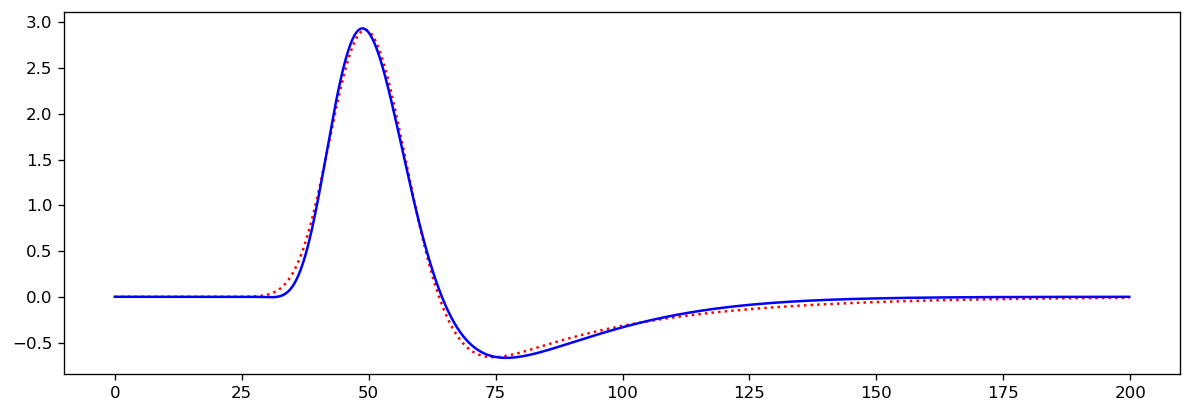

In [5]:
from scipy.optimize import curve_fit
fig = plt.figure('temporal-P_onCenter', figsize=(12,4), dpi=120)
ax = fig.add_subplot(111)

Dt_PonC = 24
Ar_PonC = 20
tauR_PonC = 2
nR_PonC = 6
Ad_PonC = 10
tauD_PonC = 10
nD_PonC = 5
# curve_fit
p0 = np.array([Ar_PonC, Ad_PonC, tauR_PonC, tauD_PonC, nR_PonC, nD_PonC])
xdata = t
ydata = Kt_onC
def kernelForFit(t, Ar, Ad, tauR, tauD, nR, nD):
    Kc, _, _ = temporalSimple(Ar, Ad, tauR, tauD, nR, nD, Dt_PonC, 0, t)
    return Kc
pfit, _ = curve_fit(kernelForFit, xdata, ydata, p0)
print(pfit)
plotKernel(pfit[0], pfit[1], pfit[2], pfit[3], pfit[4], pfit[5], Dt_PonC, 0, Kt_onC, t, ax, ':r', 'b', False)

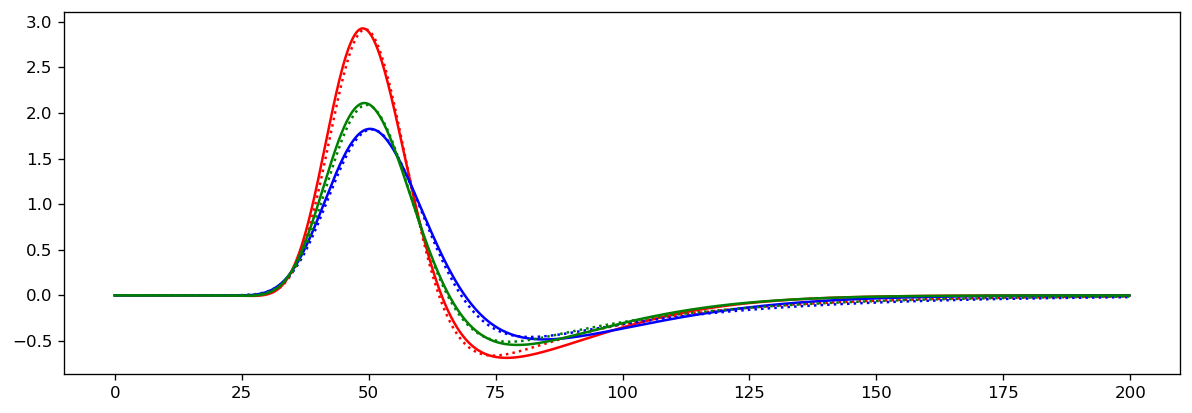

In [6]:
fig = plt.figure('temporal-P_center', figsize=(12,4), dpi=120)
ax = fig.add_subplot(111)
# manual fit ## stupid
Dt_PonC = Don*2
Ar_PonC = 64.5
tauR_PonC = 1.42
nR_PonC = 30.82
Ad_PonC = 40.0
tauD_PonC = 6.9
nD_PonC = 10.2
plotKernel(Ar_PonC, Ad_PonC, tauR_PonC, tauD_PonC, nR_PonC, nD_PonC, Dt_PonC, 0, Kt_onC, t, ax, ':r', 'r') 

Dt_PoffC = Doff*2
Ar_PoffC = 50.3
tauR_PoffC = 2.08
nR_PoffC = 22.18
Ad_PoffC = 33.4
tauD_PoffC = 8.4
nD_PoffC = 9.2
plotKernel(Ar_PoffC, Ad_PoffC, tauR_PoffC, tauD_PoffC, nR_PoffC, nD_PoffC, Dt_PoffC, 0, Kt_offC, t, ax, ':b', 'b')

Dt_PallC = Dall*2
Ar_PallC = 53.8
tauR_PallC = 1.75
nR_PallC = 25.5
Ad_PallC = 35.0
tauD_PallC = 7.4
nD_PallC = 9.5
plotKernel(Ar_PallC, Ad_PallC, tauR_PallC, tauD_PallC, nR_PallC, nD_PallC, Dt_PallC, 0, Kt_allC, t, ax, ':g', 'g')

In [7]:
t = np.arange(1000)/1000*200
# Benardete and Kaplan 1997 table 5 and 6
# center parameters
A = 27.41
HS = 0.73
tauS = 36.95
NL_tauL = 52.32
NL = 26
tauL = NL_tauL/NL
Dc = 3.5+2.95 # P-cell delay + retinogeniculate delay
Kt_c = temporalKernel(A, HS, tauS, NL, tauL, Dc, t)

In [8]:
np.sqrt(2.0*np.pi)

2.5066282746310002

LGN On-center: K = 29.132899628252794, ratio = 0.5688218056865774, tauR = 1.8987428571428568, tauD = 6.34054054054054, nR = 23.20564705882353, nD = 12.562105263157894, delay = 13.45
LGN Off-center: K = 22.71914498141264, ratio = 0.6090520954227603, tauR = 2.7812571428571427, tauD = 7.718918918918918, nR = 16.700235294117647, nD = 11.330526315789472, delay = 13.45


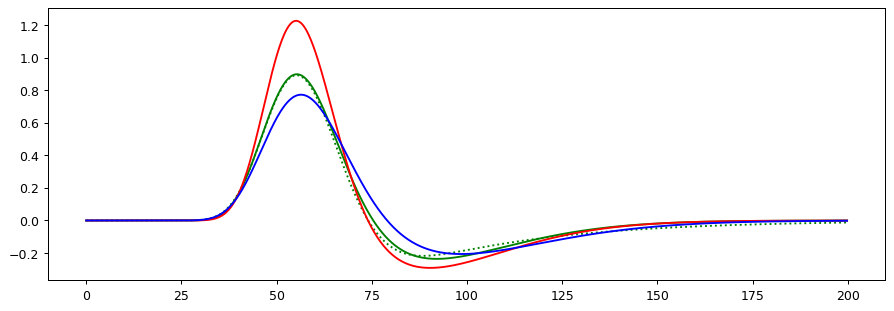

In [9]:
fig = plt.figure('temporal_LGN_C', figsize=(12,4), dpi=90)
ax = fig.add_subplot(111)
Ar_all = 24.3
Ad_all = 14.5
tauR_all = 2.34
tauD_all = 6.8
nR_all = 19.2
nD_all = 11.7
Dt_all = 0 + Dc + Dt_PallC

plotKernel(Ar_all, Ad_all, tauR_all, tauD_all, nR_all, nD_all, Dt_all, 0, Kt_c, t, ax, ':g', 'g')

Ar = Ar_all * Ar_PonC/ Ar_PallC
Ad = Ad_all * Ad_PonC/ Ad_PallC
tauR = tauR_all * tauR_PonC/ tauR_PallC
tauD = tauD_all * tauD_PonC/ tauD_PallC
nR = nR_all * nR_PonC/ nR_PallC
nD = nD_all * nD_PonC/ nD_PallC
Dt = Dt_all * Dt_PonC/ Dt_PallC
plotKernel(Ar, Ad, tauR, tauD, nR, nD, Dt, 0, None, t, ax, ':r', 'r')
print(f'LGN On-center: K = {Ar}, ratio = {Ad/Ar}, tauR = {tauR}, tauD = {tauD}, nR = {nR}, nD = {nD}, delay = {Dt}')

Ar = Ar_all * Ar_PoffC/ Ar_PallC
Ad = Ad_all * Ad_PoffC/ Ad_PallC
tauR = tauR_all * tauR_PoffC/ tauR_PallC
tauD = tauD_all * tauD_PoffC/ tauD_PallC
nR = nR_all * nR_PoffC/ nR_PallC
nD = nD_all * nD_PoffC/ nD_PallC
Dt = Dt_all * Dt_PoffC/ Dt_PallC
plotKernel(Ar, Ad, tauR, tauD, nR, nD, Dt, 0, None, t, ax, ':b', 'b')
print(f'LGN Off-center: K = {Ar}, ratio = {Ad/Ar}, tauR = {tauR}, tauD = {tauD}, nR = {nR}, nD = {nD}, delay = {Dt}')

In [10]:
t = np.arange(1000)/1000*200
# Benardete and Kaplan 1997 table 3 P cell surround
# On
A = 49.98
NL_tauL = 55.02
NL = 111
HS = 0.48
tauS = 18.62

tauL = NL_tauL/NL
Don = 3.5
Kt_onS = temporalKernel(A, HS, tauS, NL, tauL, Don, t)
# Off
A = 23.91
NL_tauL = 60.33
NL = 67
HS = 0.42
tauS = 52
tauL = NL_tauL/NL
Doff = 3.5
Kt_offS = temporalKernel(A, HS, tauS, NL, tauL, Doff, t)
# All
A = 32.92
NL_tauL = 58.68
NL = 98
HS = 0.45
tauS = 37.08
tauL = NL_tauL/NL
Dall = 3.5
Kt_allS = temporalKernel(A, HS, tauS, NL, tauL, Dall, t)

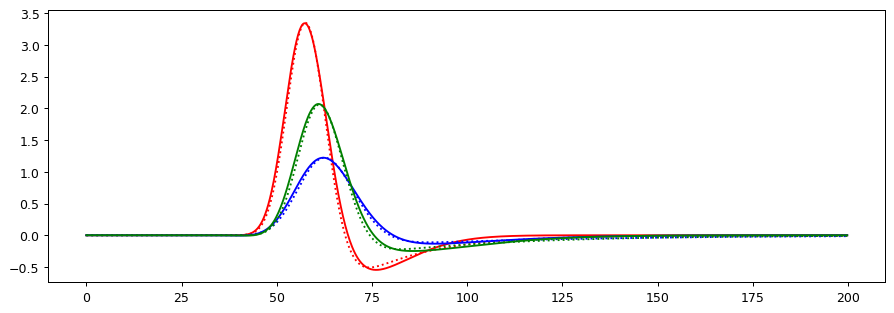

In [11]:
fig = plt.figure('temporal-P_surround', figsize=(12,4), dpi=90)
ax = fig.add_subplot(111)

Dt_PonS = Don*2 + 7.24

Ar_PonS = 49
tauR_PonS = 0.68
nR_PonS = 64.8

Ad_PonS = 18.4
tauD_PonS = 2.4
nD_PonS = 25

plotKernel(Ar_PonS, Ad_PonS, tauR_PonS, tauD_PonS, nR_PonS, nD_PonS, Dt_PonS, 0, Kt_onS, t, ax, ':r', 'r') 

Dt_PoffS = Doff*2 + 10.22

Ar_PoffS = 26.5
tauR_PoffS = 1.38
nR_PoffS = 33.8

Ad_PoffS = 9.1
tauD_PoffS = 7.6
nD_PoffS = 9.2

plotKernel(Ar_PoffS, Ad_PoffS, tauR_PoffS, tauD_PoffS, nR_PoffS, nD_PoffS, Dt_PoffS, 0, Kt_offS, t, ax, ':b', 'b')

Dt_PallS = Dall*2 + 7.52

Ar_PallS = 35.1
tauR_PallS = 0.857
nR_PallS = 55.4

Ad_PallS = 13.2
tauD_PallS = 5.9
nD_PallS = 12.2

plotKernel(Ar_PallS, Ad_PallS, tauR_PallS, tauD_PallS, nR_PallS, nD_PallS, Dt_PallS, 0, Kt_allS, t, ax, ':g', 'g')

In [12]:
# surround parameters
A = 17.07
HS = 0.46
tauS = 46.30
NL_tauL = 60.53
NL = 66
tauL = NL_tauL/NL
Ds = 3.5 + 1.21 + 6.77
Kt_s = temporalKernel(A, HS, tauS, NL, tauL, Ds, t)

In [13]:
#fig = plt.figure('temporal_LGN_S', figsize = (12,4), dpi=90)
#ax = fig.add_subplot(111)

# from curve_fit and manual adjustment
Ar_all = 16.6
Ad_all = 6.0
tauR_all = 1.14
tauD_all = 7.5
nR_all = 43.0
nD_all = 11
Dt_all = Ds + Dt_PallS - Dall

#plotKernel(Ar_all, Ad_all, tauR_all, tauD_all, nR_all, nD_all, Dt_all, 0, Kt_s, t, ax, ':g', 'g')

Ar = Ar_all * Ar_PonS/ Ar_PallS
Ad = Ad_all * Ad_PonS/ Ad_PallS
tauR = tauR_all * tauR_PonS/ tauR_PallS
tauD = tauD_all * tauD_PonS/ tauD_PallS
nR = nR_all * nR_PonS/ nR_PallS
nD = nD_all * nD_PonS/ nD_PallS
Dt = Dt_all * Dt_PonS/ Dt_PallS
#plotKernel(Ar, Ad, tauR, tauD, nR, nD, Dt, 0, None, t, ax, ':r', 'r')

print(f'LGN On-surround:\n K = {Ar},\n ratio = {Ad/Ar},\n tauR = {tauR},\n tauD = {tauD},\n nR = {nR},\n nD = {nD},\n delay = {Dt},\n tsp1 = {tauR*(nR-1)},\n tsp2 = {tauD*(nD-1)}')
Ar = Ar_all * Ar_PoffS/ Ar_PallS
Ad = Ad_all * Ad_PoffS/ Ad_PallS
tauR = tauR_all * tauR_PoffS/ tauR_PallS
tauD = tauD_all * tauD_PoffS/ tauD_PallS
nR = nR_all * nR_PoffS/ nR_PallS
nD = nD_all * nD_PoffS/ nD_PallS
Dt = Dt_all * Dt_PoffS/ Dt_PallS
#plotKernel(Ar, Ad, tauR, tauD, nR, nD, Dt, 0, None, t, ax, ':b', 'b')
print(f'LGN Off-surround:\n K = {Ar},\n ratio = {Ad/Ar},\n tauR = {tauR},\n tauD = {tauD},\n nR = {nR},\n nD = {nD},\n delay = {Dt},\n tsp1 = {tauR*(nR-1)},\n tsp2 = {tauD*(nD-1)}')

LGN On-surround:
 K = 23.173789173789174,
 ratio = 0.36090931443771374,
 tauR = 0.9045507584597433,
 tauD = 3.0508474576271185,
 nR = 50.29602888086643,
 nD = 22.54098360655738,
 delay = 22.066115702479337,
 tsp1 = 44.59076031324114,
 tsp2 = 65.71825507085302
LGN Off-surround:
 K = 12.532763532763534,
 ratio = 0.3300440182686147,
 tauR = 1.8357059509918316,
 tauD = 9.661016949152541,
 nR = 26.23465703971119,
 nD = 8.295081967213115,
 delay = 26.68388429752066,
 tsp1 = 46.323410099035755,
 tsp2 = 70.47791053070297


7.0 -> 44.0544 -> 68.88


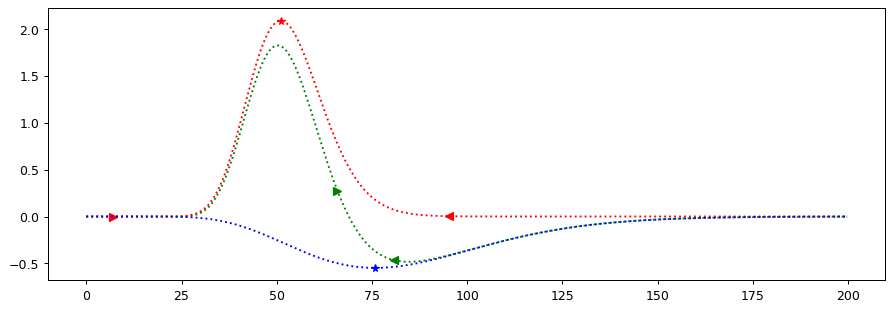

In [14]:
fig = plt.figure('model', figsize = (12,4), dpi=90)
ax = fig.add_subplot(111)

#Ar_all = 24.3
#Ad_all = 14.5
#tauR_all = 2.34
#tauD_all = 6.8
#nR_all = 19.2
#nD_all = 11.7
#Dt_all = 0 + Dc + Dt_PallC

Dt_all = Doff*2
Ar_all = 50.3
tauR_all = 2.08
nR_all = 22.18
Ad_all = 33.4
tauD_all = 8.4
nD_all = 9.2

#Ar_all = 16.6
#Ad_all = 6.0
#tauR_all = 1.14
#tauD_all = 7.5
#nR_all = 43.0
#nD_all = 11
#Dt_all = Ds + Dt_PallS - Dall
Kt0, KtR, KtD =  temporalSimple(Ar_all, Ad_all, tauR_all, tauD_all, nR_all, nD_all, Dt_all, 0, t)
plotKernel(Ar_all, Ad_all, tauR_all, tauD_all, nR_all, nD_all, Dt_all, 0, None, t, ax, '', ':g')
def point_wise(t_instant):
    K, _, _ = temporalSimple(Ar_all, Ad_all, tauR_all, tauD_all, nR_all, nD_all, Dt_all, 0, np.array([t_instant]))
    return K

def point_wiseR(t_instant):
    K = temporalComp(Ar_all, tauR_all, nR_all, Dt_all, np.array([t_instant]))
    return K

def point_wiseD(t_instant):
    K = temporalComp(Ad_all, tauD_all, nD_all, Dt_all, np.array([t_instant]))
    return K

tsp1 = tauR_all * (nR_all-1)
tsp2 = tauD_all * (nD_all-1)
def half_tau(n, tau):
    return tau*((n-1)*(np.log(n-1)-1)-np.log(2)+n-1)/(n-2)

#nR_all = 11
def poly(t):
    t = t - Dt_all
    tpick = t > 0
    active_t = t[tpick]
    p = np.zeros(t.shape)
    p[tpick] = Ar_all*np.float_power((active_t/tauR_all),(nR_all-1))/tauR_all/gamma(nR_all)
    return p

print(f'{Dt_all} -> {tsp1} -> {tsp2}')
ax.plot(tsp1+Dt_all, point_wiseR(tsp1+Dt_all),'*r')
ax.plot(Dt_all, point_wiseR(Dt_all),'>r')
ax.plot(Dt_all+2*tsp1, point_wiseR(Dt_all+2*tsp1),'<r')
ax.plot(tsp2+Dt_all, -point_wiseD(tsp2+Dt_all),'*b')
testP = Dt_all+tsp1+ tauR_all * nR_all/np.log(nR_all)*2
#testP = Dt_all+tsp1+ tauR_all * np.log(nR_all)
ax.plot(testP, point_wise(testP),'<g')
testP = Dt_all+tsp1+ tauR_all * nR_all/np.log(nR_all)
ax.plot(testP, point_wise(testP),'>g')
ax.plot(t, KtR, ':r')
ax.plot(t, -KtD, ':b')
#ax.plot(t, poly(t), ':r')
#ax.set_ylim((-0.5,1.0))

Ar_all = 16.6
Ad_all = 6.0
tauR_all = 1.14
tauD_all = 7.5
nR_all = tsp1/tauR_all
nD_all = (testP-Dt_all)/tauD_all
Dt_all = Ds + Dt_PallS - Dall

#plotKernel(Ar_all, Ad_all, tauR_all, tauD_all, nR_all, nD_all, Dt_all, 0, Kt0, t, ax, ':g', 'b')

Ar_all = 16.6
Ad_all = 6.0
tauR_all = 2.28
tauD_all = 15
nR_all = tsp1/tauR_all
nD_all = (tsp1+tauR_all*np.log(2))/tauD_all
Dt_all = Ds + Dt_PallS - Dall
#plotKernel(Ar_all, Ad_all, tauR_all, tauD_all, nR_all, nD_all, Dt_all, 0, Kt0, t, ax, ':g', 'r')